# Bimodality in the mass ratio distribution of intra-system pairs of giants

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from util import *

import pandas as pd
import copy

import diptest # https://pypi.org/project/diptest/
import matplotlib

## Process data from NASA exoplanet archive

In [2]:
filename = './tables/NASA_full/PS_2023.11.17_18.47.25.csv'
f = pd.read_csv(filename, delimiter=',', comment='#')

# strip url
def strip_url(html_link):
    if type(html_link) != str:
        return '' # empty string was converted to nan earlier...
    start_index = html_link.find('>')
    end_index = html_link.rfind('<')
    return (html_link[start_index + 1:end_index]).strip()
for name in f.columns:
    if name[-7:]=='refname':
        f[name] = [strip_url(s) for s in f[name]]


# drop rows with unreliable mass estimates (only limits, no error, or error=0)
only_limits = f['pl_bmasselim']!=0
no_err = np.isnan(f['pl_bmasseerr1']) | np.isnan(f['pl_bmasseerr2'])
zero_err = (f['pl_bmasseerr1']==0) & (f['pl_bmasseerr2']==0)
drop = only_limits | no_err | zero_err
f = f[~drop]
f.reset_index(drop=True, inplace=True)

print('table shape =',f.shape)

f[:5]

table shape = (1355, 51)


,pl_name,hostname,hd_name,default_flag,sy_snum,sy_pnum,cb_flag,rv_flag,pul_flag,ptv_flag,...,pl_rvamp,pl_rvamperr1,pl_rvamperr2,pl_rvamplim,st_refname,st_mass,st_masserr1,st_masserr2,st_masslim,st_nrvc
0,14 Her b,14 Her,HD 145675,0,1,2,0,1,0,0,...,90.000,0.500,-0.500,0.0,Wittenmyer et al. 2007,NaN,NaN,NaN,NaN,4.0
1,14 Her b,14 Her,HD 145675,0,1,2,0,1,0,0,...,90.000,0.500,-0.500,0.0,Stassun et al. 2017,0.90,0.04,-0.04,0.0,4.0
2,14 Her b,14 Her,HD 145675,0,1,2,0,1,0,0,...,90.300,1.000,-1.000,0.0,Naef et al. 2004,0.90,NaN,NaN,0.0,4.0
3,14 Her b,14 Her,HD 145675,0,1,2,0,1,0,0,...,89.490,0.650,-0.520,0.0,Rosenthal et al. 2021,0.97,0.04,-0.04,0.0,4.0
4,14 Her b,14 Her,HD 145675,1,1,2,0,1,0,0,...,89.582,0.963,-0.822,0.0,Feng et al. 2022,0.91,0.11,-0.11,0.0,4.0


In [3]:
# sanity check: any row with ill-defined error?
err = (f['pl_bmasseerr1']-f['pl_bmasseerr2'])/f['pl_bmasse']
print('rows with nan error: ',np.sum(np.isnan(err)))
print('rows with error: ',np.sum(err<=0))

rows with nan error:  0
rows with error:  0


### Load data into a nested list

In [4]:
# a list of systems
# each system contains a list of planets
# each planet contains a list of observations
# each observation is one row in the table

systems = []
for i in range(f.shape[0]):
    row = f.loc[i]
    # is this system new?
    try:
        i_sys = [sys1['name'] for sys1 in systems].index(row['hostname'])
    except:
        sys1 = {'name':row['hostname'], 'plt':[]}
        systems.append(sys1)
        i_sys = -1
    # is this planet new?
    try:
        i_plt = [plt1['name'] for plt1 in systems[i_sys]['plt']].index(row['pl_name'])
    except:
        plt1 = {'name':row['pl_name'], 'obs':[]}
        systems[i_sys]['plt'].append(plt1)
        i_plt = -1
    systems[i_sys]['plt'][i_plt]['obs'].append(row)

### Get best study for each pair
(also print all pairs with mass ratio > 0.8, sigma < 0.2, and mass > 100 M_Earth)

In [5]:
def get_mass_ratio_pair(pl1,pl2):
    ref1 = [obs['pl_refname'] for obs in pl1['obs']]
    ref2 = [obs['pl_refname'] for obs in pl2['obs']]
    common_refs = list(set(ref1).intersection(ref2))
    if len(common_refs)==0: return [], [], []
    m1 = [pl1['obs'][ref1.index(ref)]['pl_bmasse'] for ref in common_refs]
    m2 = [pl2['obs'][ref2.index(ref)]['pl_bmasse'] for ref in common_refs]
    m1e1 = [pl1['obs'][ref1.index(ref)]['pl_bmasseerr1'] for ref in common_refs]
    m2e1 = [pl2['obs'][ref2.index(ref)]['pl_bmasseerr1'] for ref in common_refs]
    m1e2 = [pl1['obs'][ref1.index(ref)]['pl_bmasseerr2'] for ref in common_refs]
    m2e2 = [pl2['obs'][ref2.index(ref)]['pl_bmasseerr2'] for ref in common_refs]
    m1err = (np.array(m1e1)-np.array(m1e2))/m1/2
    m2err = (np.array(m2e1)-np.array(m2e2))/m2/2
    sigma_m = np.sqrt(m1err**2+m2err**2)
    im = np.argmin(sigma_m)

    m_ratio = np.minimum(m1[im]/m2[im], m2[im]/m1[im])
    if m_ratio>0.8 and sigma_m[im]<0.2 and min(m1[im],m2[im])>100:
        print(m_ratio, pl1['obs'][ref1.index(common_refs[im])]['hostname'], common_refs[im])
    return [m1[im]], [m2[im]], [sigma_m[im]]

m1 = []
m2 = []
sigma_m = []
for sys in systems:
    n_pl = len(sys['plt'])
    if n_pl<2: continue
    for i in range(n_pl-1):
        for j in range(i+1,n_pl):
            res = get_mass_ratio_pair(sys['plt'][i], sys['plt'][j])
            m1 += res[0]
            m2 += res[1]
            sigma_m += res[2]

m1 = np.array(m1)
m2 = np.array(m2)
m_ratio_err = np.array(sigma_m)
m_ratio = np.minimum(m1/m2, m2/m1)
I = (m1>100) & (m2>100)
m_ratio_err = m_ratio_err[I]
m_ratio = m_ratio[I]

I = np.argsort(m_ratio_err)
m_ratio = m_ratio[I]
m_ratio_err = m_ratio_err[I]

0.8655914014872839 2MASS J19383260+4603591 Esmer et al. 2022
0.9462365605949136 2MASS J19383260+4603591 Esmer et al. 2022
0.9147727297104997 2MASS J19383260+4603591 Esmer et al. 2022
0.9378926584096212 GJ 317 Feng et al. 2020
0.8257645977677814 GJ 849 Rosenthal et al. 2021
0.862878792754333 HD 108874 Rosenthal et al. 2021
0.8327209577063172 HD 12661 Liu et al. 2014
0.9503386116207393 HD 141399 Rosenthal et al. 2021
0.86821469078137 HD 154857 Wittenmyer et al. 2014
0.9666666666666667 HD 155358 Robertson et al. 2012
0.9947368422272823 HD 156279 Rosenthal et al. 2021
0.8421652401068501 HD 169830 Rosenthal et al. 2021
0.9080118767778462 HD 181433 Horner et al. 2019
0.8928571428571428 HD 33844 Wittenmyer et al. 2016
0.965925925925926 HD 37124 Wright et al. 2011
0.9863429231337169 HD 37124 Rosenthal et al. 2021
0.9367816091954023 HD 37124 Wright et al. 2011
0.8324417094873576 HD 37605 Wang et al. 2012
0.8103683496846744 HD 73267 Feng et al. 2022
1.0 HD 73526 Wittenmyer et al. 2014
0.85809095

## Visualization

143 pairs in total


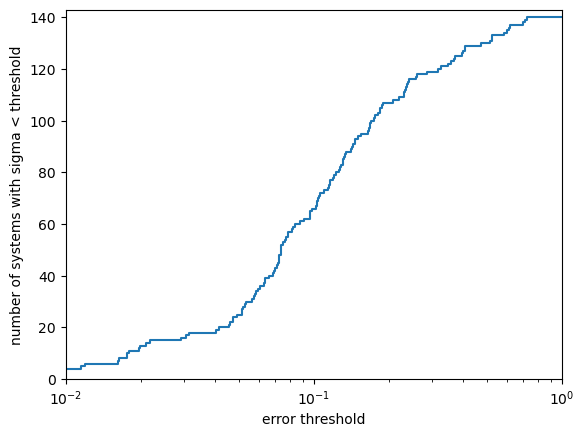

In [6]:
n = len(m_ratio)
x = np.transpose([m_ratio_err,m_ratio_err]).flatten()
y = np.transpose([np.arange(n),np.arange(n)+1]).flatten()
plt.plot(x, y)
plt.xlabel('error threshold')
plt.ylabel('number of systems with sigma < threshold')
plt.xscale('log')
plt.xlim(1e-2,1)
plt.ylim(0,n)
print(n,'pairs in total')

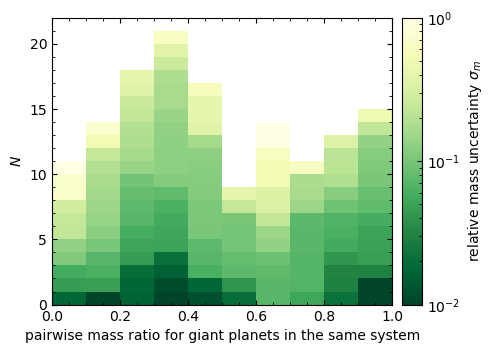

In [7]:
fig = plt.figure(figsize=(5,3.5))
fig.add_axes([0.13,0.13,0.68,0.82])
plt.gca().tick_params(right=True,top=True,which='both',direction='in')

cmap = plt.get_cmap("YlGn_r")
vmin = 1e-2
vmax = 1e0
bins = np.linspace(0,1,11)
bins[-1] = bins[-1]+1e-6
for i in range(n)[::-1]:
    cv = np.log(m_ratio_err[i]/vmin)/np.log(vmax/vmin)
    cv = np.nan_to_num(cv, nan=1)
    cv = np.maximum(np.minimum(cv, 1),0)
    c = cmap(cv)
    plt.hist(m_ratio[:i+1], bins=bins, histtype='stepfilled', lw=0, color=c)
plt.xlim(0,1)
plt.ylim(0,22)
plt.xlabel(r'pairwise mass ratio for giant planets in the same system')
plt.ylabel(r'$N$')
plt.gca().set_yticks(np.arange(0,21,5))
plt.gca().yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.05))

#plt.hist(m_ratio[m_ratio_err<0.075], bins=bins, histtype='step', lw=0.5, color='k')

cax = fig.add_axes([0.83,0.13,0.04,0.82])

norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=plt.gca(), label=r'relative mass uncertainty $\sigma_m$', cax=cax)
plt.gca().tick_params(left=False,which='both',direction='in')

#plt.savefig('./figures/giants_dichotomy_1.pdf')
plt.show()

statistically signifiance for n >= 17 and err cutoff <= 0.07499026032101638


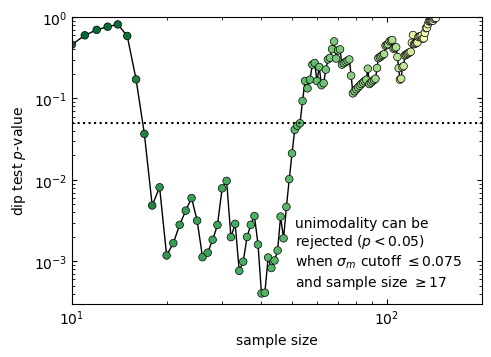

In [8]:
fig = plt.figure(figsize=(5,3.5))
fig.add_axes([0.13,0.13,0.82,0.82])
plt.gca().tick_params(right=True,top=True,which='both',direction='in')

err, p = [], []
n_sig, err_sig = [], []
for i in range(10,n+1):
    x = m_ratio[:i] # i points
    p1 = diptest.diptest(x, boot_pval=False)[1]
    p.append(p1)
    err.append(m_ratio_err[i-1])
    if p1<0.05:
        n_sig.append(i)
        err_sig.append(m_ratio_err[i-1])
print('statistically signifiance for n >=',np.amin(n_sig), 'and err cutoff <=',np.amax(err_sig))

plt.plot(np.arange(10,n+1), p, 'k', lw=1)
cmap = plt.get_cmap("YlGn_r")
vmin = 1e-2
vmax = 1e0
cv = np.log(m_ratio_err[10-1:]/vmin)/np.log(vmax/vmin)
c = cmap(cv)
plt.scatter(np.arange(10,n+1), p, c=c, edgecolor='k', lw=0.5, s=30, zorder=2)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10,200)
plt.ylim(3e-4,1)
plt.plot([1e1,2e2],[0.05,0.05],'k:')
#plt.plot([1e1,2e2],[0.5,0.5],'k:')
plt.ylabel(r'dip test $p$-value')
plt.xlabel(r'sample size')
plt.text(51, 5e-4, 'unimodality can be \nrejected ('+r'$p<0.05$'+') \nwhen '+r'$\sigma_m$'+' cutoff '+r'$\leq0.075$'+'\nand sample size '+'$\geq17$')

#plt.savefig('./figures/giants_dichotomy_2.pdf')
plt.show()

# Repeat analysis for CLS data

In [9]:
def get_mass_ratios(data, m_cutoff=0):
    m = data['m_p_mearth']
    m_err = (data['m_p_mearth_high']-data['m_p_mearth_low'])/data['m_p_mearth']/2 # 1 sigma
    I = m>=m_cutoff
    m = m[I]
    m_err = m_err[I]
    m_ratio = []
    m_ratio_err = []
    if len(m)>=2:
        for i in range(len(m)-1):
            for j in range(i+1,len(m)):
                m_ratio.append(np.minimum(m[i]/m[j], m[j]/m[i]))
                m_ratio_err.append(np.sqrt(m_err[i]**2+m_err[j]**2))
    return m_ratio, m_ratio_err

data_CLS = pickle.load(open('data/CLS.pkl','rb'))
m_ratio = np.array([d1 for d in process_data(data_CLS, get_mass_ratios, m_cutoff=100) for d1 in d[0]])
m_ratio_err = np.array([d1 for d in process_data(data_CLS, get_mass_ratios, m_cutoff=100) for d1 in d[1]])

I = np.argsort(m_ratio_err)
m_ratio = m_ratio[I]
m_ratio_err = m_ratio_err[I]

39 pairs in total


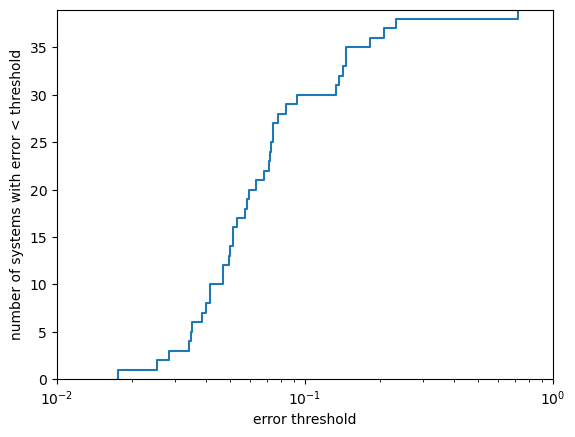

In [10]:
n = len(m_ratio)
x = np.transpose([m_ratio_err,m_ratio_err]).flatten()
y = np.transpose([np.arange(n),np.arange(n)+1]).flatten()
plt.plot(x, y)
plt.xlabel('error threshold')
plt.ylabel('number of systems with error < threshold')
plt.xscale('log')
plt.xlim(1e-2,1)
plt.ylim(0,n)
print(n,'pairs in total')

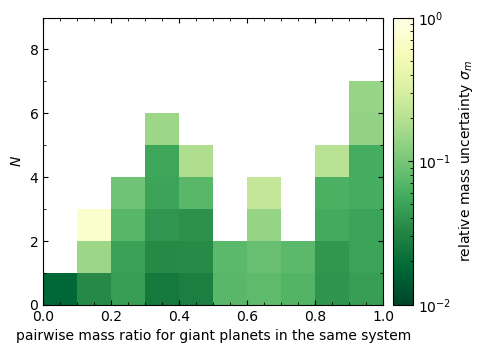

In [11]:
fig = plt.figure(figsize=(5,3.5))
fig.add_axes([0.13,0.13,0.68,0.82])
plt.gca().tick_params(right=True,top=True,which='both',direction='in')

cmap = plt.get_cmap("YlGn_r")
vmin = 1e-2
vmax = 1e0
bins = np.linspace(0,1,11)
bins[-1] = bins[-1]+1e-6
for i in range(n)[::-1]:
    cv = np.log(m_ratio_err[i]/vmin)/np.log(vmax/vmin)
    cv = np.nan_to_num(cv, nan=1)
    cv = np.maximum(np.minimum(cv, 1),0)
    c = cmap(cv)
    plt.hist(m_ratio[:i+1], bins=bins, histtype='stepfilled', lw=0, color=c)
plt.xlim(0,1)
plt.ylim(0,9)
plt.xlabel(r'pairwise mass ratio for giant planets in the same system')
plt.ylabel(r'$N$')
plt.gca().set_yticks(np.arange(0,10,2))
plt.gca().yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.05))

cax = fig.add_axes([0.83,0.13,0.04,0.82])

norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=plt.gca(), label=r'relative mass uncertainty $\sigma_m$', cax=cax)
plt.gca().tick_params(left=False,which='both',direction='in')

statistically signifiance for n >= 19 and err cutoff <= 0.07394416485081956


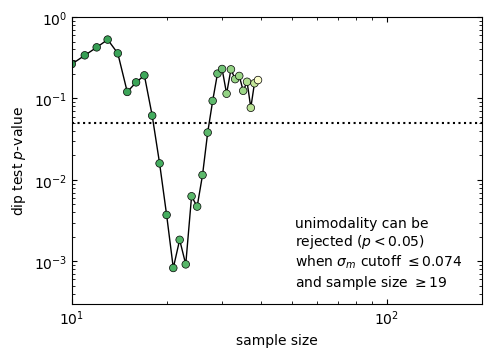

In [12]:
fig = plt.figure(figsize=(5,3.5))
fig.add_axes([0.13,0.13,0.82,0.82])
plt.gca().tick_params(right=True,top=True,which='both',direction='in')

err, p = [], []
n_sig, err_sig = [], []
for i in range(10,n+1):
    x = m_ratio[:i] # i points
    p1 = diptest.diptest(x, boot_pval=False)[1]
    p.append(p1)
    err.append(m_ratio_err[i-1])
    if p1<0.05:
        n_sig.append(i)
        err_sig.append(m_ratio_err[i-1])
print('statistically signifiance for n >=',np.amin(n_sig), 'and err cutoff <=',np.amax(err_sig))

plt.plot(np.arange(10,n+1), p, 'k', lw=1)
cmap = plt.get_cmap("YlGn_r")
vmin = 1e-2
vmax = 1e0
cv = np.log(m_ratio_err[10-1:]/vmin)/np.log(vmax/vmin)
c = cmap(cv)
plt.scatter(np.arange(10,n+1), p, c=c, edgecolor='k', lw=0.5, s=30, zorder=2)
plt.yscale('log')
plt.xscale('log')
plt.xlim(10,200)
plt.ylim(3e-4,1)
plt.plot([1e1,2e2],[0.05,0.05],'k:')
plt.ylabel(r'dip test $p$-value')
plt.xlabel(r'sample size')
plt.text(51, 5e-4, 'unimodality can be \nrejected ('+r'$p<0.05$'+') \nwhen '+r'$\sigma_m$'+' cutoff '+r'$\leq0.074$'+'\nand sample size '+'$\geq19$')
plt.show()